# Алгоритм подбора упаковки под товар

## Описание проекта и задача

Общее описание задачи: Для того, чтобы пользователь получил
заказ, необходимо упаковать заказанные товары в посылки конечному клиенту.
Компания заметила, что сотрудник тратит большое количество времени для
выбора упаковочного материала в который необходимо упаковать товары.
Существует большое количество упаковочного материала (коробочки,
пакетики). **Необходимо придумать способ подсказывать пользователю
информацию о выборе упаковочного материала.**

Есть набор данных:
* описании товара,
* категории товаров,
* ВГХ (весогабаритные характеристики) товаров,
* история предыдущих выборов сотрудников.

Необходимо разработать классификационную модель, которая позволит
подсказывать, а какой заказ упаковывать в коробки, а какие в пакетики.
При этом заказ может упаковываться в различные посылки и наша задача
минимизировать их колличество.
Выводить оценку качества модели.

### Описание данных

**Заказы (`data.csv`)**
Информация по заказам и товарам (sku), которые в них содержатся:
* `whs` - код сортировочного центра;
* `orderkey` - id заказа;
* `selected_cartontype` - код упаковки, которая была выбрана пользователем;
* `box_num` - количество коробок;
* `recommended_cartontype` - код упаковки, рекомендованной алгоритмом;
* `selected_carton` - код упаковки, которая была выбрана пользователем (дубль);
* `sel_calc_cube` - объём выбранной упаковки;
* `recommended_carton` - код упаковки, рекомендованной алгоритмом (дубль);
* `pack_volume` - рассчитанный объём упакованных товаров;
* `rec_calc_cube` - (?)
* `goods_wght` - вес товара;
* `sku` - id товара;
* `who` - упаковщик;
* `trackingid` - id доставки;

**SKU (sku.csv)**
Выгрузка id товаров и их размеров.
* `sku` - id товара
* `a`, `b`, `c`, - размеры

**Карготипы товаров (sku_cargotypes.csv)**
Выгрузка id товаров и их карготипов.
* `sku` -  id товара
* `cargotype` - карготип товара

**Описание карготипов (cargotype_info.csv)**
Таблица с идентификаторами карготипов и их описаниями
* `cargotype` -  карготип
* `description` - описание

**Характеристики упаковок (carton.csv)**
Таблица с идентификаторами и линейными размерами упаковок.
* `CARTONTYPE` - идентификатор (код) упаковки;
* `LENGTH`, `WIDTH`, `HEIGTH` - линейные размеры упаковки;
* `DISPLAYFRACK` - коробка есть на складе (не учитывать для наших целей).

**Стоимость упаковок (carton_price.xlsx)**
Таблица с идентификаторами упаковок и их стоимостью.
* идентификатор (код) упаковки
* стоимость 

### Формат выдачи

По итогу проектирования ML-продукта специалисты Data Science сформируют Docker Container: web сервис, в котором реализовано два обработчика событий (”ручки” / handler):
* `/health` - GET запрос без входных параметров. Ответ: `{”status”: “ok”}`
* `/pack` -  GET запрос, который принимает параметры заказа и возвращает рекомендованную упаковку.

https://github.com/jakubmonhart/mil_pytorch


https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


https://github.com/CTUAvastLab/Mill.jl#what-is-multiple-instance-learning-mil-problem


https://www.google.com/search?q=multi+instance+learning+pytorch&sxsrf=APwXEdc74aOvtQ4RD_Tl0NcqH018XEiu7Q%3A1686751801205&ei=OcqJZJeZDJPVrgTCypCgCA&oq=Multi+Instance+Learning+&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgcIABATEIAEMgcIABATEIAEMgcIABATEIAEMgcIABATEIAEMggIABAWEB4QEzIICAAQFhAeEBMyCggAEBYQHhAPEBMyCAgAEBYQHhATMggIABAWEB4QEzIICAAQFhAeEBM6CggAEEcQ1gQQsAM6CggAEIoFELADEENKBAhBGABQtBZYtBZgpSBoAnABeACAAa0BiAGtAZIBAzAuMZgBAKABAcABAcgBBQ&sclient=gws-wiz-serp

## Импорт библиотек

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from catboost import CatBoostRegressor, CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight

# для нейронки
from sklearn.preprocessing import LabelEncoder

In [83]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='rocket')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [84]:
RANDOM = 42

## Загрузка данных

In [86]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx', index_col='Unnamed: 0')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

#### cargotype_info 

In [ ]:
cargotype_info

Категории указаны смешано имеются как характериситики товара, тип товара, размер товара, тип склада, тип упаковки. Некоторые категории подразумевают на конкретный тип упаковки, далее проверим распределение упаковок для каждого типа товара, чтобы выбрать те в которых предпочтение склоняется в стоорону нескольких конкретных типов

Есть два значения NaN с датой удалим их

In [ ]:
cargotype_info = cargotype_info.dropna()

#### carton_price

In [ ]:
carton_price

,01.03.2023
MYA,1.109861
MYB,2.297432
MYC,3.616713
MYD,6.918375
MYE,8.062722
MYF,4.083130
YMA,4.392937
YMC,7.777487
YME,23.670260
YMF,10.661487


In [ ]:
carton_price.columns = ['price']

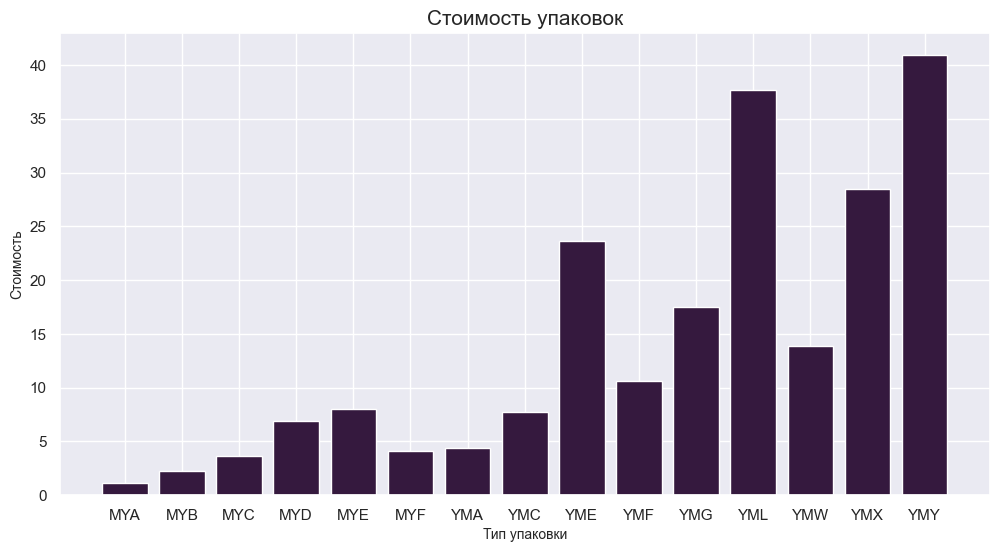

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(carton_price.index,  carton_price.price)
plt.title('Стоимость упаковок')
plt.xlabel('Тип упаковки')
plt.ylabel('Стоимость');

Таблица со стоимостью упаковок. Названия упаковок начинающиеся с `М` - пакетики, стоимость которых в среднем дешевле

#### carton

In [90]:
carton.columns = carton.columns.str.lower()
carton

,cartontype,length,width,height,displayrfpack
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,44.5,30.0,30.00,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
5,YMH,86.0,42.0,20.00,0
6,YMJ,50.0,48.0,29.00,0
7,KSD,0.0,0.0,0.00,0
8,YML,60.0,45.0,40.00,1
9,YMN,60.0,60.0,40.00,0


In [69]:
carton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cartontype     29 non-null     object 
 1   length         29 non-null     float64
 2   width          29 non-null     float64
 3   height         29 non-null     float64
 4   displayrfpack  29 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ KB


В данной таблице количество упаковок больше чем представлено в таблице с ценой. Длинна не всегда максимальна относительно других измерений, возможно ориентир относительно стороны открывания, либо данные вводятся случайно. Есть упаковки с `0` в трех измерениях логично для NONPACK & STRETCH, KSD в данных не используется.

In [89]:
carton[['length', 'width', 'height']] = carton[['length', 'width', 'height']].apply(lambda x: -np.sort(-x), raw=True, axis=1) 

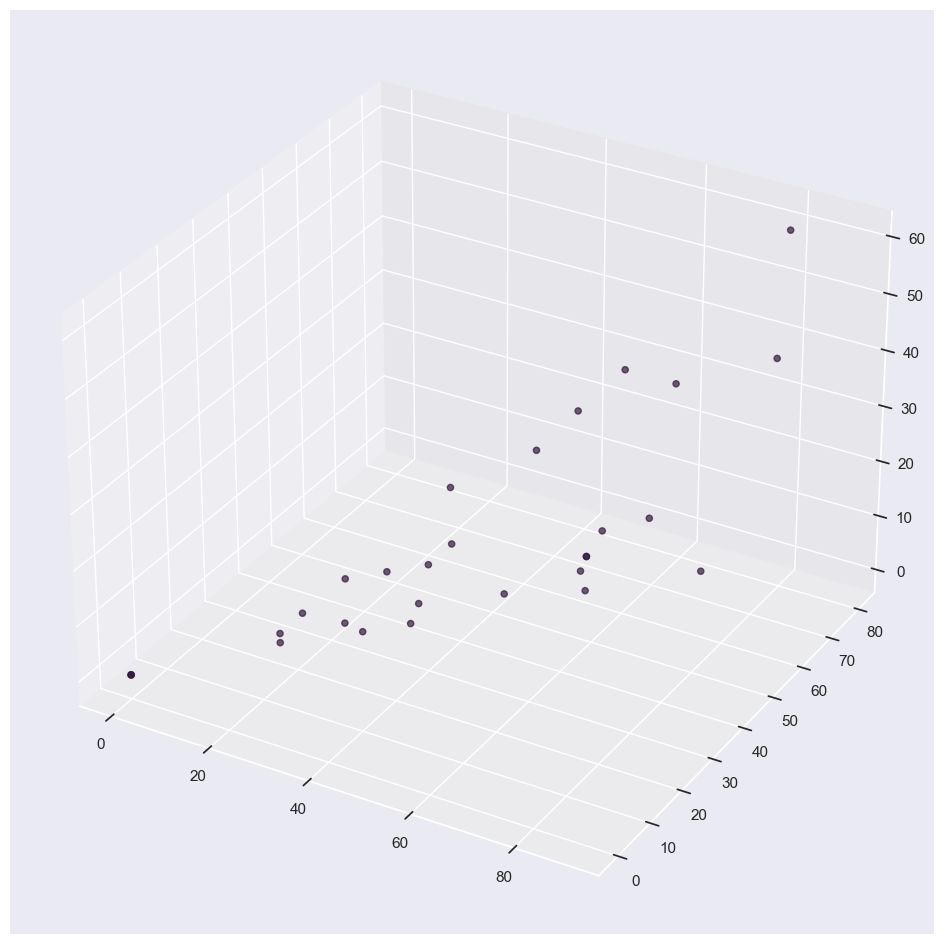

In [91]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(
    carton['length'], 
    carton['width'], 
    carton['height'], 
    #c=carton['price'], 
    alpha=0.7, 
    cmap=plt.get_cmap('hot')
    )
    
# plt.colorbar(sc, ax=ax, shrink=0.6, label='Цена')
# plt.title('Распределение стоимости автомобиля в зависимости от основных характеристик', fontsize=20)
# ax.set_xlabel('Год регистрации')
# ax.set_ylabel('Пробег, км')
# ax.set_zlabel('Мощность, л.с.')
plt.show()

In [56]:
data['selected_cartontype'].value_counts()

MYB        55937
MYC        48837
NONPACK    30497
YMC        27149
MYD        24663
YMG        23610
MYA        20401
YMF        19256
YMW        19173
YMA        15795
YME        12685
STRETCH    12465
MYE         9719
YML         3282
MYF         1350
YMX          802
YMB            2
Name: selected_cartontype, dtype: int64

In [53]:
carton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CARTONTYPE     29 non-null     object 
 1   LENGTH         29 non-null     float64
 2   WIDTH          29 non-null     float64
 3   HEIGHT         29 non-null     float64
 4   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ KB


In [14]:
data

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,7,0e4f34db53e37d6bf171c2e055e2b4e0,MYC,1,YMC,MYC,4560,YMC,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743
325619,7,0e4f34db53e37d6bf171c2e055e2b4e0,MYC,1,YMC,MYC,4560,YMC,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743
325620,7,e71d2e750ce9a7a39c273c634be1665d,YMC,1,YMC,YMC,8525,YMC,3523,8525,0.284,9db21acf9e6c1a66493c246c1461f989,be7c9ad8b9430d358e6c276b94e2beff,58054d533ef06746ffd8cf99fad4a8cb
325621,7,2e2a642f611b5a6f2c404ab945fbc2a3,MYB,1,YMU,MYB,2816,YMU,552,2592,0.230,4aedb72c5662562524f6119918c7179b,be7c9ad8b9430d358e6c276b94e2beff,1666b5c878be124f05fb9a1d95dd8a68


In [15]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,30.0,30.0,44.50,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
5,YMH,42.0,20.0,86.00,0
6,YMJ,50.0,29.0,48.00,0
7,KSD,0.0,0.0,0.00,0
8,YML,60.0,40.0,45.00,1
9,YMN,60.0,60.0,40.00,0


In [16]:
data.query('selected_cartontype == "YMB"')

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
306135,6,488f30086440836580d685f1d62739d9,YMB,1,YMW,YMB,32722,YMW,7488,21812,1.74,93cde1e32be271140e6974b2f1ad0a1d,cc13d6620f94635b8f376aa2eb70f119,3b6cced2a8d9a7e3e55e81b55559a909
306136,6,488f30086440836580d685f1d62739d9,YMB,1,YMW,YMB,32722,YMW,7488,21812,1.74,93cde1e32be271140e6974b2f1ad0a1d,cc13d6620f94635b8f376aa2eb70f119,3b6cced2a8d9a7e3e55e81b55559a909


In [17]:
data['selected_cartontype'].value_counts().keys()

Index(['MYB', 'MYC', 'NONPACK', 'YMC', 'MYD', 'YMG', 'MYA', 'YMF', 'YMW',
       'YMA', 'YME', 'STRETCH', 'MYE', 'YML', 'MYF', 'YMX', 'YMB'],
      dtype='object')

In [18]:
sku_cargotypes

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290
...,...,...
21053147,5786e5c2309967c64b10e443ce1a807c,691
21053148,859788a147004b9a1d24a8168460f79a,200
21053149,859788a147004b9a1d24a8168460f79a,290
21053150,859788a147004b9a1d24a8168460f79a,310


In [19]:
all_data = data.merge(sku_cargotypes, on='sku', how='left')

In [20]:
all_data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,cargotype
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,290.0
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,600.0
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,610.0
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,950.0
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,970.0


In [21]:
all_data = all_data[['selected_cartontype', 'cargotype']]

In [22]:
all_data.sample(12)

,selected_cartontype,cargotype
1346020,YMG,485.0
573935,YMG,750.0
1453036,NONPACK,340.0
1051335,MYB,901.0
1222994,MYB,901.0
504709,NONPACK,960.0
320016,MYA,290.0
948272,STRETCH,485.0
1411602,YMG,1011.0
143071,MYB,690.0


In [23]:
pivot_all_data = all_data.pivot_table(index='selected_cartontype', columns='cargotype', aggfunc=len, fill_value=0) #size
#pivot_all_data = pivot_all_data.apply(lambda x: x / x.sum(), axis=1)
# выбираем 10 наиболее частых cargotype
top_cargo = pivot_all_data.sum().sort_values(ascending=False).head(995).index.tolist()

# фильтруем сводную таблицу по top_cargo и переводим значения в относительные частоты
pivot_all_data = pivot_all_data[top_cargo].apply(lambda x: x / x.sum())
pivot_all_data.columns = pivot_all_data.columns.astype(int)

In [24]:
display(pivot_all_data.style.format('{:.2f}').background_gradient('coolwarm'))

cargotype,290,340,410,750,690,780,441,520,360,480,320,490,440,310,720,200,950,485,691,1010,960,801,291,770,692,901,460,640,400,970,1011,120,980,920,292,710,600,641,955,905,671,672,621,305,670,911,301,300,910,160,908,601,610,330,622,302,130,623,620,611,990,673,81,0,799,350,140,315,40,303,510,900,931,790,110,210,1300,751,20,930
selected_cartontype,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MYA,0.07,0.04,0.04,0.03,0.12,0.03,0.11,0.04,0.03,0.06,0.03,0.09,0.12,0.08,0.02,0.10,0.04,0.03,0.11,0.03,0.02,0.06,0.01,0.02,0.04,0.18,0.07,0.14,0.06,0.04,0.02,0.02,0.02,0.03,0.00,0.02,0.04,0.05,0.07,0.22,0.04,0.10,0.04,0.00,0.10,0.03,0.00,0.00,0.24,0.11,0.31,0.08,0.03,0.44,0.05,0.00,0.06,0.03,0.03,0.04,0.04,0.14,0.40,0.07,0.07,0.00,0.20,0.01,0.71,0.05,0.15,0.26,0.00,0.21,0.00,0.33,0.00,0.00,0.00,0.00
MYB,0.19,0.11,0.13,0.10,0.28,0.10,0.29,0.13,0.07,0.20,0.09,0.27,0.32,0.14,0.09,0.24,0.13,0.11,0.28,0.07,0.07,0.15,0.02,0.07,0.19,0.35,0.27,0.40,0.21,0.13,0.07,0.09,0.06,0.12,0.00,0.06,0.11,0.15,0.17,0.42,0.17,0.27,0.13,0.01,0.26,0.07,0.00,0.00,0.38,0.26,0.44,0.37,0.04,0.27,0.17,0.00,0.24,0.02,0.02,0.00,0.12,0.39,0.45,0.09,0.37,0.00,0.36,0.02,0.17,0.24,0.44,0.35,0.26,0.29,0.46,0.50,0.50,1.00,0.00,0.00
MYC,0.16,0.12,0.15,0.13,0.17,0.16,0.17,0.14,0.09,0.18,0.12,0.16,0.18,0.09,0.11,0.17,0.20,0.18,0.17,0.09,0.10,0.14,0.03,0.09,0.16,0.17,0.18,0.16,0.20,0.21,0.12,0.15,0.14,0.14,0.01,0.13,0.24,0.17,0.11,0.14,0.20,0.22,0.29,0.02,0.20,0.05,0.00,0.00,0.19,0.18,0.13,0.31,0.18,0.09,0.25,0.00,0.20,0.09,0.07,0.09,0.12,0.14,0.07,0.07,0.17,0.00,0.14,0.03,0.02,0.19,0.22,0.04,0.05,0.36,0.15,0.00,0.25,0.00,1.00,0.00
MYD,0.08,0.07,0.07,0.05,0.05,0.08,0.05,0.06,0.09,0.07,0.06,0.05,0.04,0.04,0.05,0.09,0.17,0.10,0.09,0.06,0.06,0.09,0.07,0.06,0.07,0.05,0.05,0.04,0.07,0.19,0.06,0.11,0.14,0.07,0.01,0.05,0.23,0.13,0.05,0.02,0.13,0.10,0.24,0.02,0.10,0.11,0.00,0.00,0.04,0.09,0.03,0.06,0.24,0.02,0.14,0.00,0.07,0.17,0.15,0.22,0.05,0.06,0.02,0.04,0.09,0.00,0.01,0.05,0.02,0.02,0.00,0.04,0.42,0.07,0.00,0.00,0.00,0.00,0.00,0.00
MYE,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.05,0.02,0.02,0.03,0.01,0.02,0.01,0.03,0.09,0.02,0.03,0.02,0.02,0.03,0.09,0.02,0.02,0.02,0.01,0.01,0.02,0.11,0.02,0.04,0.06,0.02,0.01,0.03,0.10,0.05,0.01,0.01,0.05,0.03,0.08,0.01,0.03,0.14,0.01,0.01,0.01,0.01,0.01,0.01,0.12,0.02,0.07,0.00,0.01,0.22,0.23,0.08,0.01,0.01,0.00,0.09,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MYF,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.02,0.00,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NONPACK,0.04,0.17,0.03,0.03,0.04,0.04,0.03,0.05,0.07,0.04,0.06,0.05,0.01,0.11,0.05,0.09,0.11,0.06,0.07,0.09,0.25,0.18,0.45,0.12,0.21,0.02,0.01,0.03,0.02,0.10,0.03,0.19,0.12,0.01,0.77,0.02,0.07,0.21,0.03,0.00,0.05,0.08,0.01,0.83,0.12,0.18,0.89,0.90,0.01,0.07,0.00,0.01,0.10,0.00,0.01,0.89,0.04,0.06,0.07,0.07,0.28,0.00,0.00,0.01,0.03,0.96,0.01,0.68,0.02,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
STRETCH,0.02,0.05,0.02,0.01,0.03,0.02,0.02,0.03,0.10,0.03,0.03,0.05,0.00,0.02,0.02,0.06,0.06,0.05,0.06,0.04,0.02,0.10,0.25,0.06,0.13,0.03,0.01,0.02,0.01,0.05,0.01,0.09,0.07,0.01,0.19,0.01,0.03,0.16,0.03,0.00,0.07,0.04,0.00,0.05,0.08,0.05,0.09,0.08,0.00,0.02,0.00,0.00,0.13,0.01,0.00,0.11,0.02,0.04,0.04,0.16,0.08,0.01,0.01,0.03,0.01,0.04,0.04,0.05,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
YMA,0.05,0.05,0.06,0.07,0.06,0.06,0.06,0.04,0.03,0.05,0.05,0.05,0.08,0.09,0.09,0.08,0.01,0.02,0.04,0.03,0.04,0.02,0.00,0.09,0.06,0.05,0.09,0.09,0.05,0.00,0.06,0.02,0.02,0.11,0.00,0.04,0.00,0.01,0.08,0.08,0.03,0.02,0.00,0.00,0.02,0.07,0.00,0.00,0.04,0.04,0.02,0.01,0.00,0.04,0.00,0.00,0.04,0.00,0.00,0.00,0.02,0.07,0.02,0.10,0.04,0.0

In [25]:
display(pivot_all_data.loc[:, pivot_all_data.max() >= 0.3].style.format('{:.2f}').background_gradient('coolwarm'))

cargotype,440,291,901,640,292,905,305,301,300,910,908,601,330,302,673,81,799,350,140,315,40,510,900,931,790,110,210,1300,751,20,930
selected_cartontype,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MYA,0.12,0.01,0.18,0.14,0.00,0.22,0.00,0.00,0.00,0.24,0.31,0.08,0.44,0.00,0.14,0.40,0.07,0.00,0.20,0.01,0.71,0.15,0.26,0.00,0.21,0.00,0.33,0.00,0.00,0.00,0.00
MYB,0.32,0.02,0.35,0.40,0.00,0.42,0.01,0.00,0.00,0.38,0.44,0.37,0.27,0.00,0.39,0.45,0.37,0.00,0.36,0.02,0.17,0.44,0.35,0.26,0.29,0.46,0.50,0.50,1.00,0.00,0.00
MYC,0.18,0.03,0.17,0.16,0.01,0.14,0.02,0.00,0.00,0.19,0.13,0.31,0.09,0.00,0.14,0.07,0.17,0.00,0.14,0.03,0.02,0.22,0.04,0.05,0.36,0.15,0.00,0.25,0.00,1.00,0.00
MYD,0.04,0.07,0.05,0.04,0.01,0.02,0.02,0.00,0.00,0.04,0.03,0.06,0.02,0.00,0.06,0.02,0.09,0.00,0.01,0.05,0.02,0.00,0.04,0.42,0.07,0.00,0.00,0.00,0.00,0.00,0.00
MYE,0.01,0.09,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MYF,0.01,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.02,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NONPACK,0.01,0.45,0.02,0.03,0.77,0.00,0.83,0.89,0.90,0.01,0.00,0.01,0.00,0.89,0.00,0.00,0.03,0.96,0.01,0.68,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
STRETCH,0.00,0.25,0.03,0.02,0.19,0.00,0.05,0.09,0.08,0.00,0.00,0.00,0.01,0.11,0.01,0.01,0.01,0.04,0.04,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
YMA,0.08,0.00,0.05,0.09,0.00,0.08,0.00,0.00,0.00,0.04,0.02,0.01,0.04,0.00,0.07,0.02,0.04,0.00,0.02,0.00,0.00,0.12,0.13,0.05,0.00,0.00,0.00,0.25,0.00,0.00,0.00


In [26]:
corr_cargo_carton_categ = pivot_all_data.loc[:, pivot_all_data.max() >= 0.5].columns
corr_cargo_carton_categ

Int64Index([292, 305, 301, 300, 302, 350, 315, 40, 210, 1300, 751, 20, 930], dtype='int64', name='cargotype')

In [27]:
# явно отсортированные
not_need_box = [360, 340]

In [28]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

carton_price.columns = ['cartontype', 'price']
carton.columns = [s.lower() for s in carton.columns]

In [29]:
carton_price

,cartontype,price
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722
5,MYF,4.083130
6,YMA,4.392937
7,YMC,7.777487
8,YME,23.670260
9,YMF,10.661487


In [30]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype in @corr_cargo_carton_categ') # дропаем слишком шумные
sku_cargotypes_filtred['cargotype'] = sku_cargotypes_filtred['cargotype'].astype('Int64', errors='ignore').fillna(0)

In [31]:
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left').dropna() # 
sku_groups.head()

,sku,cargotype
10,0eabf1bdc973f7721769ded3747e6ce8,[292]
14,c564ff80254cc97773de5668b397780f,[292]
17,d5291922d9d516141e386203e1e7dfc1,[292]
21,1b77f3da72e68eef3c8a73c8932d7bf2,"[292, 300, 301, 302]"
23,06076bee03b035cb460ca9cb680d76f7,[292]


In [32]:
sku_groups.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2634 entries, 10 to 86515
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku        2634 non-null   object
 1   cargotype  2634 non-null   object
dtypes: object(2)
memory usage: 61.7+ KB


In [33]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [34]:
sku.isna().sum()

sku    0
a      0
b      0
c      0
dtype: int64

In [35]:
sku[['a', 'b', 'c']] = sku[['a', 'b', 'c']].apply(lambda x: np.sort(x), raw=True, axis=1) 

In [36]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [37]:
# non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [38]:
# # фичи для упаковок, для сравнения с фичами заказа
# new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
# new_carton = new_carton.rename(
#     columns={
#         'level_0': 'carton_dim',
#         0: 'value'
# })

# new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
# new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
# new_carton_t =  new_carton.set_index('carton_type_dim').T

In [39]:
df = data.copy()

In [40]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [41]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


In [42]:
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(sku_groups['cargotype'])
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df['sku'] = sku_groups['sku']

In [43]:
one_hot_df

,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku
0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
2,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,1,1,1,1,0,0,0,0,0,0,NaN
4,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,0,0,0,1,0,0,0,1,0,0,0,0,0,NaN
2630,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
2631,0,0,0,1,1,1,1,0,0,0,0,0,0,NaN
2632,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN


In [44]:
df = pd.merge(df, one_hot_df, on='sku', how='left')
df = df.fillna(0)

In [45]:
df.describe()

,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300
count,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.0,325623.0,325623.0,325623.000000,325623.000000,325623.000000,325623.000000,325623.000000,325623.000000,325623.0,325623.0,325623.0,325623.0
mean,2.787773,11188.402656,5.440790e+03,1.134705,0.0,0.0,0.0,0.004855,0.000587,0.000676,0.000181,0.000369,0.000009,0.0,0.0,0.0,0.0
std,15.774209,13958.516542,2.858190e+04,4.090043,0.0,0.0,0.0,0.069511,0.024212,0.025984,0.013460,0.019193,0.003035,0.0,0.0,0.0,0.0
min,1.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,1.000000,3449.000000,5.000000e+02,0.110000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,1.000000,8436.000000,1.192000e+03,0.300000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,1.000000,15579.000000,3.154000e+03,0.799000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,235.000000,108000.000000,1.815450e+06,153.700000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0


In [46]:
sku = sku[sku['vol']>0]

In [47]:
sku

,sku,a,b,c,dim_sum,vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,28.0,31.0,70.0,9548.0,23.0,28.0,308.0,341.0,868.0,308.0,505.0,43.2
1,d9af6ce6f9e303f4b1a8cb47cde21975,14.0,29.0,40.0,83.0,16240.0,27.0,29.0,406.0,560.0,1160.0,406.0,708.0,51.4
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,60.0,5460.0,20.0,13.0,156.0,420.0,455.0,156.0,343.0,39.2
3,e8af308a7659e34194770d1e3a48e144,3.0,8.0,13.0,24.0,312.0,8.0,8.0,24.0,39.0,104.0,24.0,55.0,15.6
4,dc0e2542e122731217289b8e6d3bd3f8,18.0,56.0,96.0,170.0,96768.0,56.0,56.0,1008.0,1728.0,5376.0,1008.0,2704.0,112.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6280078,beed9b9bbc5db2fbd2156709e5aa87fe,2.5,30.0,30.0,62.5,2250.0,20.0,30.0,75.0,75.0,900.0,75.0,350.0,42.5
6280079,d19e623480d2daf996f7af7395bcd8d5,5.0,30.0,30.0,65.0,4500.0,21.0,30.0,150.0,150.0,900.0,150.0,400.0,42.7
6280080,7e86666e7d2a64e81d0d3515dece322c,10.0,10.0,20.0,40.0,2000.0,13.0,10.0,100.0,200.0,200.0,100.0,166.0,24.5
6280081,11a4769a51dd25cee8da65245a42cd65,4.0,8.0,18.0,30.0,576.0,10.0,8.0,32.0,72.0,144.0,32.0,82.0,20.1


In [48]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4


In [49]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
20                     0
40                     0
210                    0
292                    0
300                    0
301                    0
302                    0
305                    0
315                    0
350                    0
751                    0
930                    0
1300                   0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [50]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [51]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,48.0,2046.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,20.0,26.0,50.0,2080.0,16.0,20.0,80.0,104.0,520.0,80.0,234.0,33.0
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,20.0,26.0,50.0,2080.0,16.0,20.0,80.0,104.0,520.0,80.0,234.0,33.0
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,51.9,3523.0,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,23.0,37.0,552.0,12.0,12.0,24.0,46.0,276.0,24.0,115.0,26.0


In [52]:
df_sum = df.drop(['selected_carton', 'sku'], axis=1).groupby('orderkey', sort=False).sum() # суммируем по заказам

In [53]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,451.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,7626.0,13981.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,71.6,3050.0,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,75.0,15180.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,68.5,6561.0,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,65.3,6346.0,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,88.0,88.0,202.0,50336.0,66.0,88.0,1144.0,1144.0,3872.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,100.0,4160.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,51.9,3523.0,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9


In [54]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [55]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [56]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,451.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,7626.0,13981.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,5.2,2.8,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,71.6,3050.0,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,15.1,2.7,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,75.0,15180.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.4,1.3,1.0,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,68.5,6561.0,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,4.1,3.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,65.3,6346.0,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,4.2,1.4,1.0,3.3,61.3,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,88.0,88.0,202.0,50336.0,66.0,88.0,1144.0,1144.0,3872.0,1144.0,2052.0,127.2,NONPACK,101.0,33.666667,25168.000,3.4,1.0,1.0,0.5,28.6,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,100.0,4160.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,6.5,1.3,1.0,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,51.9,3523.0,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,3.0,2.7,1.0,0.8,9.4,23.6
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,23.0,37.0,552.0,12.0,12.0,24.0,46.0,276.0,24.0,115.0,26.0,MYB,37.0,12.333333,552.000,11.5,1.9,1.0,4.2,10.0,23.5


In [57]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [58]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
# df_sum[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()
# df_sum[new_carton_t.filter(like='length').columns.tolist()] = new_carton_t[new_carton_t.filter(like='length').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [59]:
df = df.drop('orderkey', axis=1)

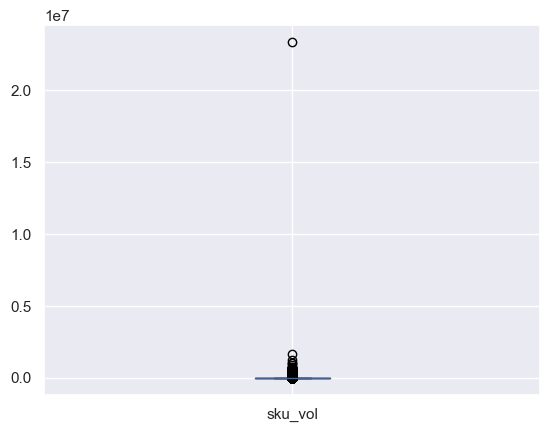

In [60]:
df_sum['sku_vol'].plot(kind='box');

In [61]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

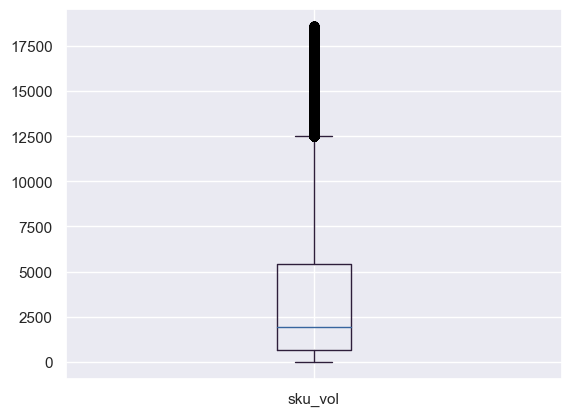

In [62]:
df_no_outlier_vol['sku_vol'].plot(kind='box');

In [63]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [64]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,71.6,3050.0,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,15.1,2.7,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,75.0,15180.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.4,1.3,1.0,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,68.5,6561.0,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,4.1,3.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,65.3,6346.0,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,4.2,1.4,1.0,3.3,61.3,33.4
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,29.0,29.0,67.0,7569.0,22.0,29.0,261.0,261.0,841.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,3.2,1.0,1.0,8.0,209.7,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,18.0,25.0,52.0,4050.0,17.0,18.0,162.0,225.0,450.0,162.0,279.0,32.1,YMC,52.0,17.333333,4050.000,2.8,1.4,1.0,4.3,69.6,24.6
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,142.2,251.4,406.2,12510.0,132.0,138.0,294.0,522.0,5958.0,294.0,2256.0,289.2,YMW,67.7,22.566667,2085.363,20.0,1.8,1.0,1.0,4.9,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,100.0,4160.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,6.5,1.3,1.0,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,51.9,3523.0,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,3.0,2.7,1.0,0.8,9.4,23.6


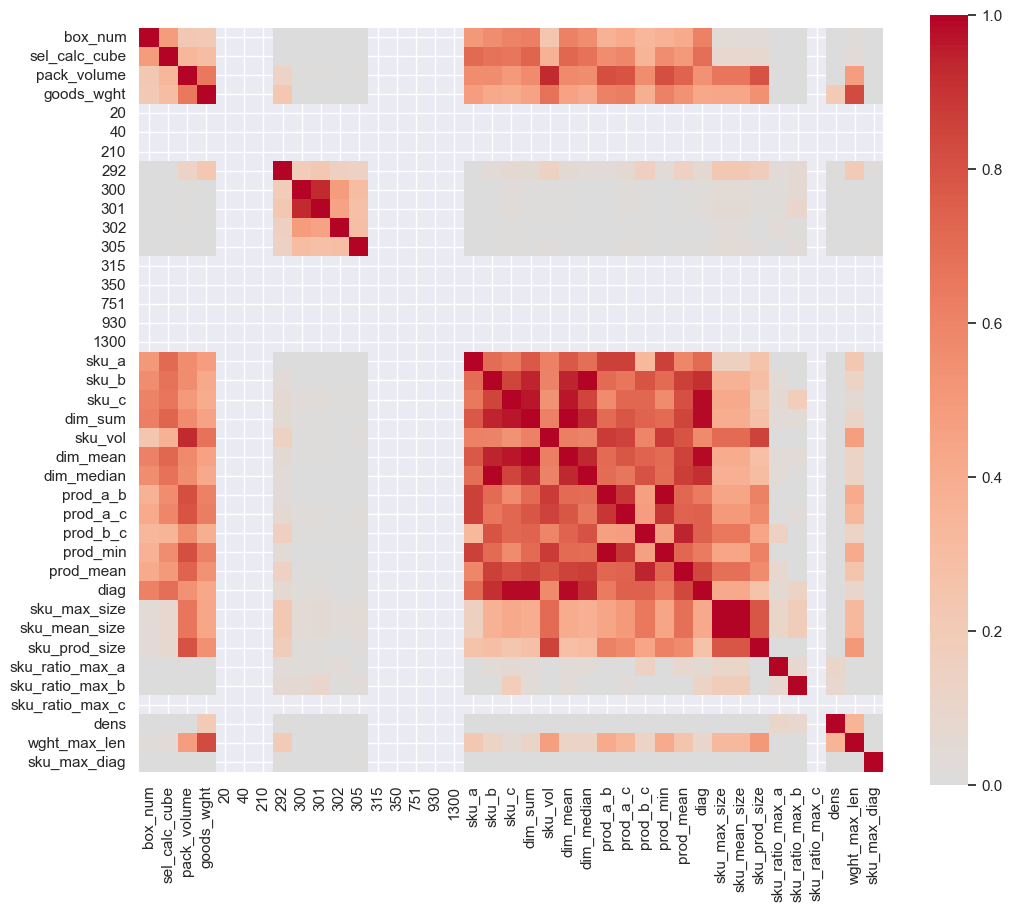

In [65]:
numeric_columns = df_no_outlier_vol.loc[:,df_no_outlier_vol.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            #annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [66]:
corr_feat = set()
corr_matrix = df_no_outlier_vol[numeric_columns].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{301,
 'diag',
 'dim_mean',
 'dim_median',
 'dim_sum',
 'prod_a_b',
 'prod_a_c',
 'prod_mean',
 'prod_min',
 'sku_mean_size',
 'sku_prod_size',
 'sku_vol'}

In [67]:
# Проверить
# df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

In [68]:
# fltr_nonpack =  ["STRETCH", "NONPACK"] # 
# df_no_outlier_vol = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')
# df_no_outlier_vol

In [70]:
df_no_outlier_vol.query('selected_carton == "YMB"')

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
147754,488f30086440836580d685f1d62739d9,2,65444,14976,3.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,39.0,48.0,119.0,14976.0,38.0,38.0,624.0,768.0,936.0,624.0,776.0,69.6,YMB,59.5,19.833333,7488.0,1.5,1.2,1.0,2.3,72.5,28.1


# Модель 1

In [57]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"') # один случай дропаем из-за stratify

In [58]:
df_no_outlier_vol = df_no_outlier_vol.dropna()

In [59]:
df_no_outlier_vol['selected_carton'].value_counts()

selected_carton
MYB        39498
MYC        29024
MYA        14358
MYD        12772
YMC         7916
NONPACK     7823
YMA         6729
STRETCH     5321
YMF         4036
MYE         3959
YMW         3407
YMG         2560
MYF          789
YME          322
YMX           29
YML            7
Name: count, dtype: int64

In [60]:
from fedot.api.main import Fedot

In [61]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,71.6,3050.0,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,15.1,2.7,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,75.0,15180.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.4,1.3,1.0,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,68.5,6561.0,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,4.1,3.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,65.3,6346.0,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,4.2,1.4,1.0,3.3,61.3,33.4
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,29.0,29.0,67.0,7569.0,22.0,29.0,261.0,261.0,841.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,3.2,1.0,1.0,8.0,209.7,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,18.0,25.0,52.0,4050.0,17.0,18.0,162.0,225.0,450.0,162.0,279.0,32.1,YMC,52.0,17.333333,4050.000,2.8,1.4,1.0,4.3,69.6,24.6
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,142.2,251.4,406.2,12510.0,132.0,138.0,294.0,522.0,5958.0,294.0,2256.0,289.2,YMW,67.7,22.566667,2085.363,20.0,1.8,1.0,1.0,4.9,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,100.0,4160.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,6.5,1.3,1.0,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,51.9,3523.0,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,3.0,2.7,1.0,0.8,9.4,23.6


In [62]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [63]:
categorical = list(corr_cargo_carton_categ.astype(str))
print(f"Категориальные признаки: {categorical}")

numerical = list(set(X_train.columns) - set(categorical))
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['292', '305', '301', '300', '302', '350', '315', '40', '210', '1300', '751', '20', '930']
Числовые признаки: ['sku_ratio_max_a', 'prod_a_c', 'sku_ratio_max_b', 'sku_prod_size', 'sku_c', 'diag', 'dim_mean', 'wght_max_len', 'prod_a_b', 'sku_max_size', 'sku_max_diag', 'sku_ratio_max_c', 'dens', 'dim_sum', 'prod_min', 'prod_mean', 'sku_mean_size', 'goods_wght', 'sku_a', 'prod_b_c', 'sku_b', 'sku_vol', 'dim_median']


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC

In [78]:
X_train.shape

(103912, 36)

In [85]:
catbc = CatBoostClassifier(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        iterations=500,
        #subsample=0.1,
        #max_depth=5,
        verbose=100,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='AUC',
        #cat_features=corr_cargo_carton_categ.to_list()
        )
lgbmc = LGBMClassifier(random_state=42)
mlpc = MLPClassifier([36,36,36,36,36,36], verbose=True)

ovrc = OneVsOneClassifier(catbc, n_jobs=4).fit(X_train, y_train)

In [87]:
tree_preds = ovrc.predict(X_test)
#tree_pred_proba = ovrc.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, ovrc.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')
#print(f'AUC: {roc_auc_score(y_test, tree_pred_proba, average="weighted", multi_class="ovr")}')

print(classification_report(y_test, tree_preds))

ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (34638,)

In [66]:
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
num_pipe = Pipeline([('scaler', RobustScaler())])

preprocessor = ColumnTransformer(
     [
         ('cat', cat_pipe, categorical),
         #('num', num_pipe, numerical), #0.888529
     ], remainder ='passthrough') 

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("regressor", LGBMClassifier())
    ]
)

param_grid = [
     {
         'regressor': [CatBoostClassifier(
             random_state=42, 
             #verbose=100,
             silent=True,
             early_stopping_rounds=10,
             #task_type='GPU',
             #devices='0:1',
             loss_function='MultiClass',
             eval_metric='AUC',
             )],
         'regressor__iterations': range(500, 900, 100),
         'regressor__depth' : range(5, 9, 2),
         #'regressor__l2_leaf_reg': range(1, 13, 1),
         #'regressor__learning_rate': np.linspace(0.01, 0.5, 15),
         #'regressor__auto_class_weights': ['SqrtBalanced']#['Balanced', ]
     },
    # {
    #     'regressor': [LGBMClassifier(random_state=42, objective='multiclass')],
    #     'regressor__max_depth': range(3, 8, 1), #up 18
    #     'regressor__learning_rate': np.linspace(0.01, 0.09, 5), #[0.1, 0.3, 0.5, 0.01, 0.03], lo 0.01
    #     'regressor__n_estimators': range(200, 800, 100),
    #     # 'regressor__max_bin': range(100, 800, 100),
    #     # 'regressor__min_data_in_leaf': range(10, 300, 10),
    #     'regressor__l2_leaf_reg': np.linspace(0.0001, 1.0, 10),
    #     # 'regressor__subsample': np.linspace(0.1, 0.9, 9)
    # },
    # {
    #      'regressor': [MLPClassifier(
    #          random_state=42, 
    #          early_stopping=True,
    #          max_iter=1000,

    #          )],
    #      'regressor__hidden_layer_sizes': [(50,50,50,50,50,50,50,50,50,50,50,50)], 
    #      'regressor__learning_rate': ['adaptive'],
    #      'regressor__learning_rate_init': [0.0001, 0.00001, 0.0005]

    # }    
]


grid = RandomizedSearchCV(pipe, param_grid, n_iter=5, cv=5, verbose=4, random_state=42) #scoring = 'roc_auc', 

In [67]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END regressor=<catboost.core.CatBoostClassifier object at 0x000001FF1F1B6560>, regressor__depth=5, regressor__iterations=600;, score=0.491 total time= 1.4min


KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__iterations,param_regressor__depth,param_regressor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,370.663528,31.953939,0.355180,0.020007,800,7,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__iterations': 800, 'regressor__dep...",0.490449,0.487273,0.494033,0.490473,0.497931,0.492032,0.003644,1
0,101.755237,9.850312,0.358421,0.021034,600,5,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__iterations': 600, 'regressor__dep...",0.490738,0.486118,0.492494,0.487297,0.498605,0.491050,0.004420,2
4,97.167443,3.087582,0.292401,0.012925,700,5,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__iterations': 700, 'regressor__dep...",0.492085,0.483857,0.495814,0.487008,0.496247,0.491002,0.004875,3
1,336.462631,29.651916,0.375767,0.072986,600,7,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__iterations': 600, 'regressor__dep...",0.488236,0.486022,0.492638,0.488836,0.494418,0.490030,0.003058,4
2,77.432659,1.794223,0.294602,0.014011,500,5,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__iterations': 500, 'regressor__dep...",0.492903,0.483665,0.491242,0.485228,0.495092,0.489626,0.004430,5


In [ ]:
from sklearn import metrics

In [ ]:
predicted_valid = grid.best_estimator_.predict_proba(X_test)[:, 1] #grid.best_estimator_.predict(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_valid)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})')
plt.show()

ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
predicted_valid = np.where(predicted_valid > 0.5, 1, 0)
conf_mx = confusion_matrix(y_test, predicted_valid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mx)
cm_display.plot()
accuracy = accuracy_score(y_test, predicted_valid)
plt.show()
print(f'Accuracy на тестовой выборке составляет {accuracy}')

ValueError: Mix of label input types (string and number)

In [ ]:
grid.best_estimator_.named_steps["regressor"].get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'MultiClass',
 'iterations': 700,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '0:1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'od_wait': 10,
 'class_names': ['MYA',
  'MYB',
  'MYC',
  'MYD',
  'MYE',
  'MYF',
  'NONPACK',
  'STRETCH',
  'YMA',
  'YMC',
  'YME',
  'YMF',
  'YMG',
  'YML',
  'YMW',
  'YMX'],
 'random_seed': 42,
 'depth': 6,
 'border

In [ ]:
model = Fedot(problem='classification', timeout=10, preset='best_quality', n_jobs=4, metric='roc_auc') # best_quality
model.fit(features=X_train, target=y_train)
prediction = model.predict(features=X_test)
metrics = model.get_metrics(target=y_test)

In [ ]:
metrics

{'roc_auc': 0.797, 'f1': 0.47}

In [ ]:
# X_train.to_csv('X_train.csv')
# X_test.to_csv('X_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')


In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostClassifier(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        iterations=500,
        #subsample=0.1,
        #max_depth=5,
        verbose=10,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='AUC',
        #cat_features=corr_cargo_carton_categ.to_list()
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.180114
0:	total: 1.56s	remaining: 13m
10:	total: 9.25s	remaining: 6m 51s
20:	total: 16.5s	remaining: 6m 15s
30:	total: 23.9s	remaining: 6m 1s
40:	total: 31.2s	remaining: 5m 49s
50:	total: 40.6s	remaining: 5m 57s
60:	total: 48.8s	remaining: 5m 50s
70:	total: 55.9s	remaining: 5m 37s
80:	total: 1m 10s	remaining: 6m 6s
90:	total: 1m 19s	remaining: 5m 58s
100:	total: 1m 28s	remaining: 5m 47s
110:	total: 1m 36s	remaining: 5m 39s
120:	total: 1m 46s	remaining: 5m 32s
130:	total: 1m 54s	remaining: 5m 22s
140:	total: 2m 3s	remaining: 5m 13s
150:	total: 2m 11s	remaining: 5m 3s
160:	total: 2m 18s	remaining: 4m 52s
170:	total: 2m 26s	remaining: 4m 42s
180:	total: 2m 34s	remaining: 4m 31s
190:	total: 2m 41s	remaining: 4m 21s
200:	total: 2m 49s	remaining: 4m 12s
210:	total: 3m 3s	remaining: 4m 11s
220:	total: 3m 14s	remaining: 4m 5s
230:	total: 3m 26s	remaining: 4m
240:	total: 3m 43s	remaining: 4m
250:	total: 3m 54s	remaining: 3m 52s
260:	total: 4m 3s	remaining: 3m 43s
270:	tot

Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x0000025FC15316C0>)])

Text(0.5, 1.0, 'Feature Importance')

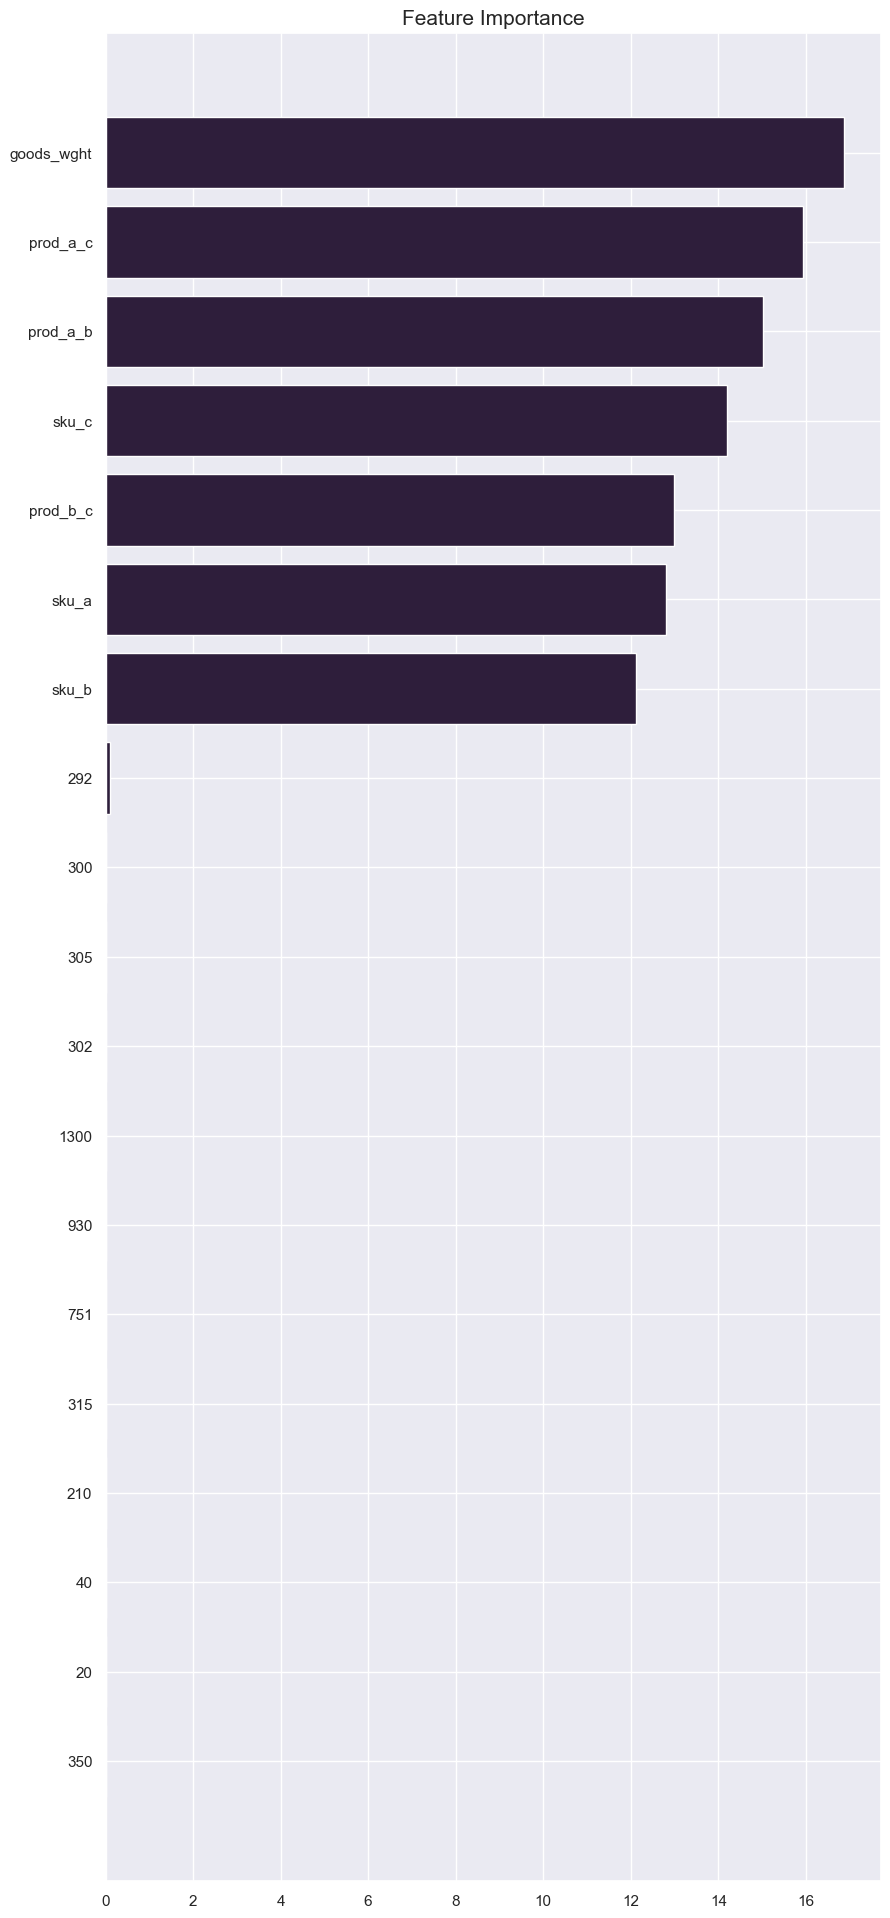

In [ ]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [73]:

tree_preds = ovrc.predict(X_test)
#tree_pred_proba = ovrc.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, ovrc.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')
#print(f'AUC: {roc_auc_score(y_test, tree_pred_proba, average="weighted", multi_class="ovr")}')

print(classification_report(y_test, tree_preds))

TRAIN ACC: 0.5760354915697898
TEST ACC: 0.4934753738668514
TEST F1: 0.4831322060159679
              precision    recall  f1-score   support

         MYA       0.56      0.45      0.50      3590
         MYB       0.60      0.67      0.63      9875
         MYC       0.49      0.55      0.52      7256
         MYD       0.39      0.47      0.42      3193
         MYE       0.30      0.17      0.21       990
         MYF       0.10      0.01      0.01       197
     NONPACK       0.51      0.57      0.54      1956
     STRETCH       0.34      0.23      0.28      1330
         YMA       0.43      0.18      0.26      1682
         YMC       0.37      0.34      0.36      1979
         YME       0.21      0.04      0.06        80
         YMF       0.28      0.26      0.27      1009
         YMG       0.37      0.36      0.36       640
         YML       0.00      0.00      0.00         2
         YMW       0.31      0.37      0.34       852
         YMX       0.00      0.00      0.00     

In [ ]:
y_proba = ovrc.predict_proba(X_test[100:110])

# два наиболее вероятных класса с вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = ovrc.classes_[top_two[i]]
    print(f"Для заказа № {i} рекомендуется упаковка: {class_names[0]}, {top_two_proba[i][0]*100}% или {class_names[1]}, {top_two_proba[i][1]*100}%, тест {y_test.iloc[i]}")

Для заказа № 0 рекомендуется упаковка: YMG, 21.0% или YMW, 53.0%, тест STRETCH
Для заказа № 1 рекомендуется упаковка: MYB, 36.0% или MYC, 48.0%, тест MYC
Для заказа № 2 рекомендуется упаковка: STRETCH, 36.0% или NONPACK, 61.0%, тест YMF
Для заказа № 3 рекомендуется упаковка: MYC, 27.0% или YMA, 53.0%, тест STRETCH
Для заказа № 4 рекомендуется упаковка: YMA, 15.0% или MYB, 70.0%, тест MYB
Для заказа № 5 рекомендуется упаковка: MYB, 39.0% или MYA, 56.00000000000001%, тест MYB
Для заказа № 6 рекомендуется упаковка: MYC, 28.999999999999996% или MYB, 60.0%, тест MYC
Для заказа № 7 рекомендуется упаковка: MYC, 11.0% или YMC, 56.99999999999999%, тест MYC
Для заказа № 8 рекомендуется упаковка: MYA, 20.0% или MYB, 64.0%, тест YMF
Для заказа № 9 рекомендуется упаковка: YMG, 14.000000000000002% или MYE, 19.0%, тест YMA


In [ ]:
tree_pipe.predict_proba(X_test)[:, 1]

array([0.15675098, 0.30328914, 0.01037809, ..., 0.01296531, 0.26569097,
       0.0666241 ])

In [ ]:
y_test

81523     MYC
13379     MYA
98829     MYD
8503      YMW
100456    MYC
         ... 
16149     MYC
123963    MYC
36679     MYC
83450     MYA
121923    MYA
Name: selected_carton, Length: 34645, dtype: object

In [ ]:
from sklearn.metrics import roc_auc_score

predicted_valid = tree_pipe.predict(X_test) #grid.best_estimator_.predict(X_train)
fpr, tpr, thresholds = roc_auc_score(y_test, predicted_valid, average="weighted", multi_class="ovr")
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})')
plt.show()

ValueError: could not convert string to float: 'MYC'

# Модель 2

In [ ]:
# расчет по объему поэтому 0 отбрасываем
zero_vol = ['KSD', 'NONPACK', 'STRETCH']

In [ ]:
carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

In [ ]:
df_no_outlier_vol_regr = pd.merge(df_no_outlier_vol, 
         carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}), 
         on='selected_carton', 
         how='left')

df_no_outlier_vol_regr = df_no_outlier_vol_regr.dropna()

In [ ]:
X = df_no_outlier_vol_regr.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey', 'vol'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol_regr['vol']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol_regr['vol']
                                                    )

In [ ]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostRegressor(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        #iterations=1000,
        #subsample=0.1,
        #max_depth=4,
        verbose=100,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        #loss_function='MultiClass',
        #eval_metric='TotalF1',
        eval_metric="RMSE"
        ))
])

tree_pipe.fit(X_train, y_train)

In [ ]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
cartontype_sorted_vol = carton[['cartontype','vol']].query('cartontype not in @zero_vol').rename(columns={"cartontype": "selected_carton", "vol": "vol"}).sort_values('vol')

In [ ]:
threshold = y_proba[0]
cartontype_sorted_vol['diff'] = np.abs(cartontype_sorted_vol['vol'] - threshold)
cartontype_sorted_vol = cartontype_sorted_vol.sort_values('diff')

# получение первых двух строк с diff > 0
result = cartontype_sorted_vol[cartontype_sorted_vol['diff'] > 0].head(2)['selected_carton'].values
print(result)

# Модель 3

In [ ]:
def base_line(order):
    '''
    Получаем order -- json запрос с перечнем товаров
    ищем минимально возможную упаковку из словаря boxes для всех товаров
    Возвращаем {"orderid": "sdfsdf", "package": "ADC", "status": "ok"}
    !!! нет проверок на типы
    !!! если есть товар который не влезет выдаст None, проверки по остальным не сделает
    '''

    def multiply_min(lst, number):
        '''
        типотеза что сложение предметов в пачку идет в первую очередь по меньшему размеру
        '''
        min_val = min(lst)
        min_index = lst.index(min_val)
        lst[min_index] *= number
        return lst

    orderId = order['orderId']
    bricks = [] # размеры товаров в список
    vol_range = {} # объемы для последующего отсева наиболее объемных
    for i in order['items']:
        sizes = (float(i['size1']), float(i['size2']), float(i['size3']))
        sizes = multiply_min(list(sizes), i['count'])
        vol_range[i['sku']] = float(i['size1']) * float(i['size2']) * float(i['size3'])
        bricks.append(sizes)
        # for j in range(i['count']):
        #
    # размеры коробок
    boxes = {
        'KSD': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'STRETCH': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'NONPACK': {'x': 0.0, 'y': 0.0, 'z': 0.0},
        'MYA': {'x': 15.0, 'y': 20.0, 'z': 3.33},
        'MYF': {'x': 20.0, 'y': 15.0, 'z': 5.0},
        'YMU': {'x': 27.0, 'y': 24.0, 'z': 4.0},
        'MYB': {'x': 22.0, 'y': 32.0, 'z': 4.9},
        'YMA': {'x': 24.7, 'y': 15.0, 'z': 10.0},
        'YMV': {'x': 37.0, 'y': 29.0, 'z': 4.0},
        'MYC': {'x': 30.0, 'y': 38.0, 'z': 7.4},
        'YMC': {'x': 30.0, 'y': 20.0, 'z': 15.0},
        'YMF': {'x': 35.0, 'y': 25.0, 'z': 15.0},
        'MYD': {'x': 38.0, 'y': 50.0, 'z': 8.2},
        'YMW': {'x': 40.0, 'y': 30.0, 'z': 15.0},
        'MYE': {'x': 43.0, 'y': 63.0, 'z': 9.7},
        'YMG': {'x': 44.7, 'y': 30.0, 'z': 20.0},
        'YME': {'x': 30.0, 'y': 30.0, 'z': 44.5},
        'YMP': {'x': 70.0, 'y': 30.0, 'z': 22.0},
        'YMХ': {'x': 40.0, 'y': 18.0, 'z': 65.0},
        'YMO': {'x': 65.0, 'y': 45.0, 'z': 20.0},
        'YMJ': {'x': 50.0, 'y': 29.0, 'z': 48.0},
        'YMH': {'x': 42.0, 'y': 20.0, 'z': 86.0},
        'YMY': {'x': 52.0, 'y': 20.0, 'z': 70.0},
        'YML': {'x': 60.0, 'y': 40.0, 'z': 45.0},
        'YMN': {'x': 60.0, 'y': 60.0, 'z': 40.0},
        'YMQ': {'x': 70.0, 'y': 60.0, 'z': 40.0},
        'YMS': {'x': 89.5, 'y': 59.5, 'z': 49.5},
        'YMR': {'x': 80.0, 'y': 60.0, 'z': 80.0}
    }

    def is_fitting(box, bricks):
        for brick in bricks:
            if box['x'] < brick[0] or box['y'] < brick[1] or box['z'] < brick[2]:
                return False
            box = {
                'x': max(box['x'] - brick[0], 0),
                'y': max(box['y'] - brick[1], 0),
                'z': max(box['z'] - brick[2], 0)
            }
        return True

    def find_box(bricks, boxes):
        min_box = None
        min_vol = float('inf')
        for box_name, box in boxes.items():
            if is_fitting(box, bricks):
                vol = box['x'] * box['y'] * box['z']
                if vol < min_vol:
                    min_box = box_name
                    min_vol = vol
        return min_box

    def answer(orderId=orderId, min_box_name='None', status='ok'):
        answer = {}
        answer['orderid'] = orderId
        answer['package'] = min_box_name
        answer['status'] = 'ok'
        return answer

    if find_box(bricks, boxes) != 'None':
        return answer(min_box_name=find_box(bricks, boxes))
    else:
        return answer(min_box_name='STRETCH')

    #
    # while
    #     vol_range.pop(max(vol_range))

    # return min_box_name


order = {"orderId": "af49bf330e2cf16e44f0be1bdfe337bd",
 "items": [
    {"sku": "unique_sku_1", "count": 2,
     "size1": "12", "size2": "6", "size3": "3",
     "weight": "7.34", "type": ["2"]},
    {"sku": "unique_sku_2", "count": 3,
     "size1": "4", "size2": "5.23", "size3": "6.2",
     "weight": "7.45", "type": ["8", "9", "10"]},
    {"sku": "unique_sku_3", "count": 2,
     "size1": "11", "size2": "12.5", "size3": "13.3",
     "weight": "14.2", "type": ["15", "16"]}
   ]
}

print(base_line(order))

{'orderid': 'af49bf330e2cf16e44f0be1bdfe337bd', 'package': 'YMJ', 'status': 'ok'}
